C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator TfidfTransformer from version 1.4.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 1.4.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(

[0]
Document 8999 Similarity: 0.44816075281741213
Document 46876 Similarity: 0.4401553769449658
Document 689 Similarity: 0.43570917121212216
Document 8483 Similarity: 0.40199969733768326
Document 9226 Similarity: 0.3876297797387313
Document 8683 Similarity: 0.384123950250568
Document 5465 Similarity: 0.3807659893675083
Document 7063 Similarity: 0.37712788253051055
Document 6490 Similarity: 0.37696803529494755
Document 9101 Similarity: 0.37334325363854914


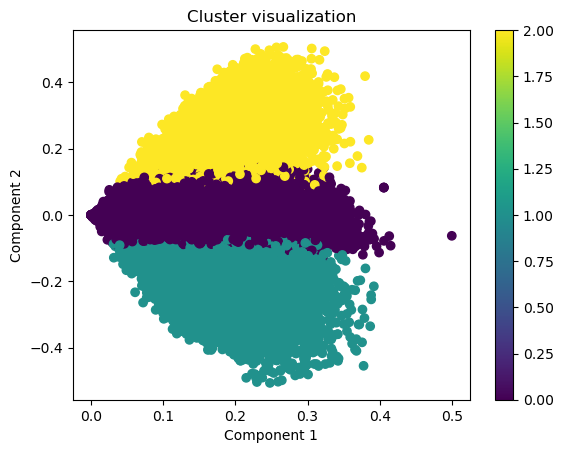

In [1]:
import json
from Services.Data_Preprocessing import DataPreprocessing
from Services.Data_Indexing import Indexing
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt
import logging
import os
import pickle
class Clustering:
    def __init__(self, num_clusters=3):
        self.num_clusters = num_clusters
   
    def train_kmeans(self, tfidf_matrix,datasetName):
        model_file=f'{datasetName}/kmeans_model.json'
        kmeans = KMeans(n_clusters=self.num_clusters, random_state=42)
        kmeans.fit(tfidf_matrix)

        # Save the trained KMeans model to a JSON file
        kmeans_model = kmeans
        data = {
            "kmeans_model": kmeans_model,
            "tfidf_matrix": tfidf_matrix,
        }
        with open(model_file, "wb") as f:
            pickle.dump(data,f)

    def predict_and_get_similar_documents(self, query_tfidf,datasetName):
        model_file=f'{datasetName}/kmeans_model.json'
        # Load the trained KMeans model from the JSON file
        with open(model_file, 'rb') as f:
            data = pickle.load(f)
            kmeans_model = data['kmeans_model']
            tfidf_matrix= data['tfidf_matrix']
   

        query_cluster = kmeans_model.predict(query_tfidf)
        print(query_cluster)

        # Calculating Cosine Similarity
        cluster_mask =kmeans_model.labels_ == query_cluster[0]
        cluster_documents = tfidf_matrix[cluster_mask]
        similarities = cosine_similarity(query_tfidf, cluster_documents)

        # Display the most similar documents
        most_similar_docs_indices = np.argsort(similarities[0])[::-1][:10]
        similar_documents = []
        for index in most_similar_docs_indices:
            similar_documents.append((index, similarities[0][index]))
            print(f"Document {index} Similarity: {similarities[0][index]}")

        return similar_documents
    def visualize_clusters(self,datasetName):
        model_file=f'{datasetName}/kmeans_model.json'
        with open(model_file, 'rb') as f:
            data = pickle.load(f)
            kmeans_model = data['kmeans_model']
            tfidf_matrix= data['tfidf_matrix']
            
        try:
            if kmeans_model is None:
                raise ValueError("KMeans model has not been fitted yet. Call 'fit_kmeans' first.")

            logging.debug("Starting visualization.")
            svd = TruncatedSVD(n_components=2)
            reduced_data = svd.fit_transform(tfidf_matrix)

            plt.figure()  # Start a new figure
            plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=kmeans_model.labels_)
            plt.title('Cluster visualization')
            plt.xlabel('Component 1')
            plt.ylabel('Component 2')
            plt.colorbar()  # Show color scale
            plt.show()
            # Ensure the directory exists
            output_dir = 'static'
            if not os.path.exists(output_dir):
                os.makedirs(output_dir)

            # Save the figure to a file
            plt.savefig(os.path.join(output_dir, 'cluster_plot.png'))
            plt.close()  # Close the figure to free up memory

            logging.debug("Visualization saved to {}/cluster_plot.png".format(output_dir))
        except Exception as e:
            logging.error("Error in visualization process: %s", e)
            raise
kmeans = Clustering()
indexing = Indexing()
data_preprocessing = DataPreprocessing()
tf_idf_file = 'lifestyle/vectorized_data.json'
query = 'Why does my cat keep patting my face?'
clean_query = data_preprocessing.clean_query(query,'lifestyle')
tfidf_matrix, query_vector = indexing.query_vectorize_C(clean_query, tf_idf_file)
kmeans.train_kmeans(tfidf_matrix,'lifestyle')
kmeans.predict_and_get_similar_documents(query_vector,'lifestyle')
kmeans.visualize_clusters('lifestyle')